In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICE'] = ''
import random

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import torch

%load_ext autoreload
%autoreload 2

from importlib.util import find_spec
if find_spec("text_recognizer") is None:
    import sys
    sys.path.append('..')

from text_recognizer.data.iam_paragraphs import IAMParagraphs
from text_recognizer.data.iam_synthetic_paragraphs import IAMSyntheticParagraphs
from text_recognizer.data.iam_extended_paragraphs import IAMExtendedParagraphs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def _plot(image, figsize=(12,12), title='', vmin=0, vmax=255):
    plt.figure(figsize=figsize)
    if title:
        plt.title(title)
    plt.imshow(image, cmap='gray', vmin=vmin, vmax=vmax)

def convert_y_label_to_string(y, mapping, padding_index=3):
    return ''.join([mapping[int(i)] for i in y if i != padding_index])

In [4]:
from hydra import compose, initialize
from omegaconf import OmegaConf
from hydra.utils import instantiate

In [6]:
# context initialization
with initialize(config_path="../training/conf/"):
    cfg = compose(config_name="config", overrides=["+experiment=conv_transformer_paragraphs"])

In [7]:
datamodule = instantiate(cfg.datamodule)
datamodule.prepare_data()
datamodule.setup()
print(datamodule)

2021-10-27 22:19:04.371 | INFO     | text_recognizer.data.iam_paragraphs:setup:92 - Loading IAM paragraph regions and lines for None...
2021-10-27 22:19:24.358 | DEBUG    | text_recognizer.data.transforms.load_transform:_load_config:17 - Loading transforms from config: transform/paragraphs.yaml
2021-10-27 22:19:27.633 | DEBUG    | text_recognizer.data.transforms.load_transform:_load_config:17 - Loading transforms from config: test_transform/paragraphs.yaml
2021-10-27 22:19:27.638 | INFO     | text_recognizer.data.iam_synthetic_paragraphs:setup:67 - IAM Synthetic dataset steup for stage None...
2021-10-27 22:19:40.131 | DEBUG    | text_recognizer.data.transforms.load_transform:_load_config:17 - Loading transforms from config: transform/paragraphs.yaml


IAM Original and Synthetic Paragraphs Dataset
Num classes: 58
Dims: (1, 576, 640)
Output dims: (682, 1)
Train/val/test sizes: 19931, 262, 231
Train Batch x stats: (torch.Size([4, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0084), tensor(0.0509), tensor(0.9961))
Train Batch y stats: (torch.Size([4, 682]), torch.int64, tensor(1), tensor(57))
Test Batch x stats: (torch.Size([4, 1, 576, 640]), torch.float32, tensor(0.), tensor(0.0321), tensor(0.0744), tensor(0.8118))
Test Batch y stats: (torch.Size([4, 682]), torch.int64, tensor(1), tensor(57))



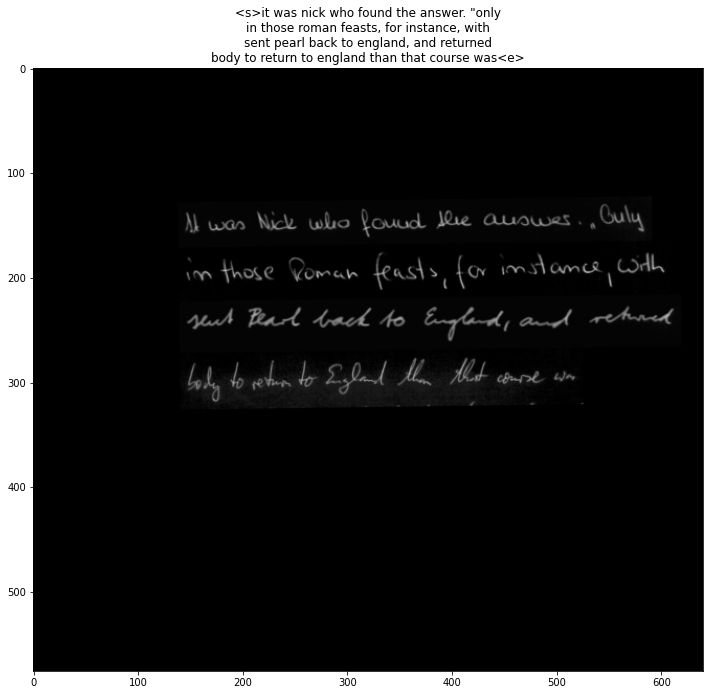

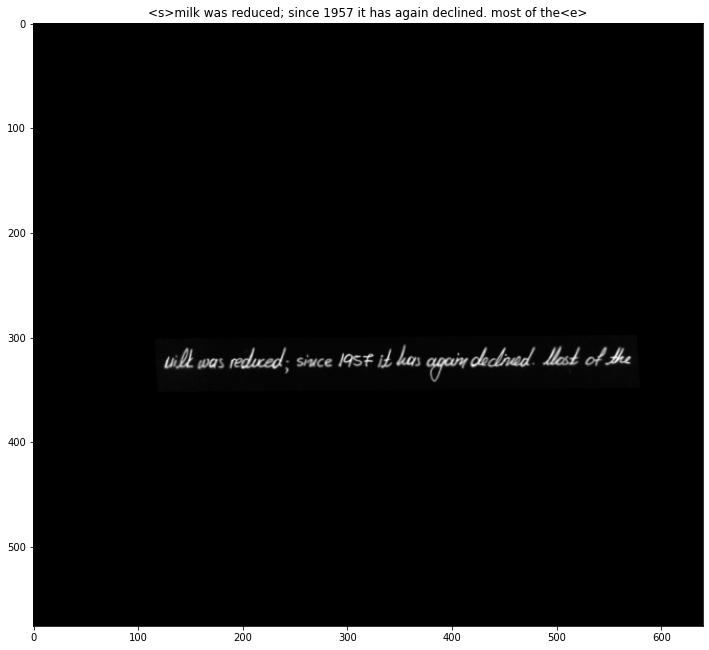

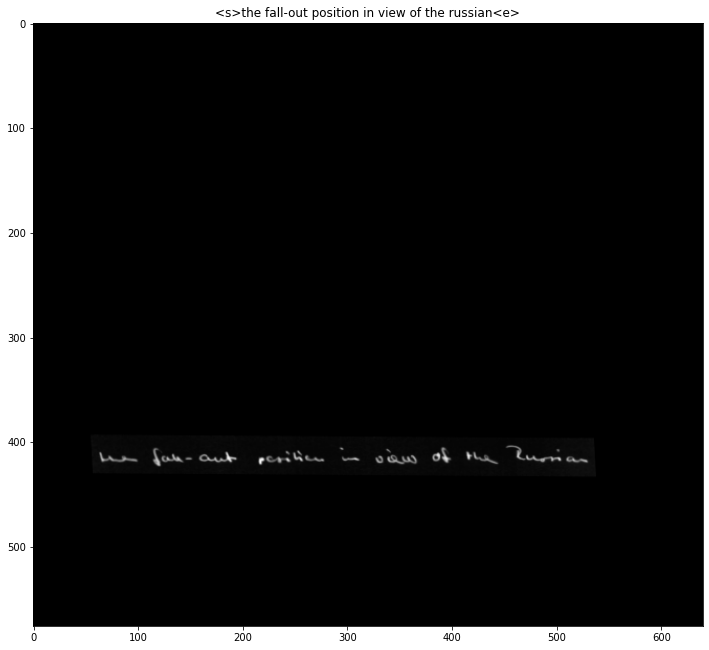

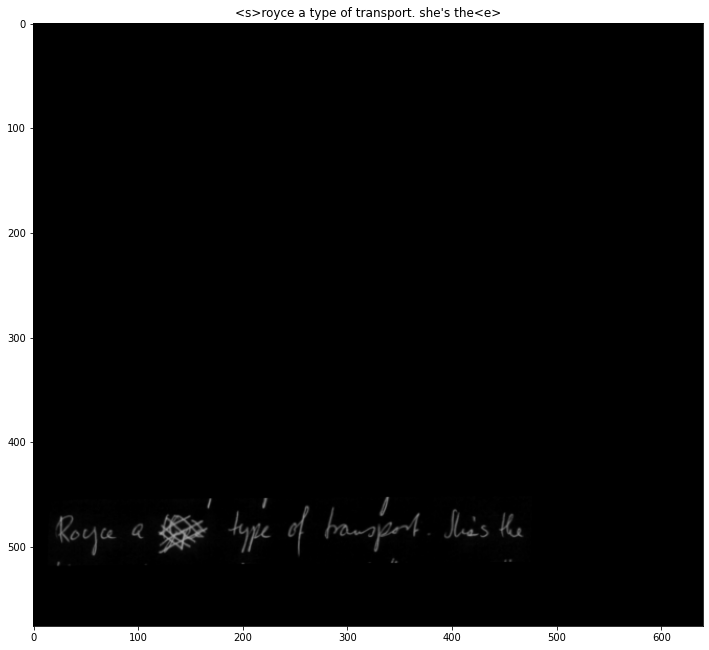

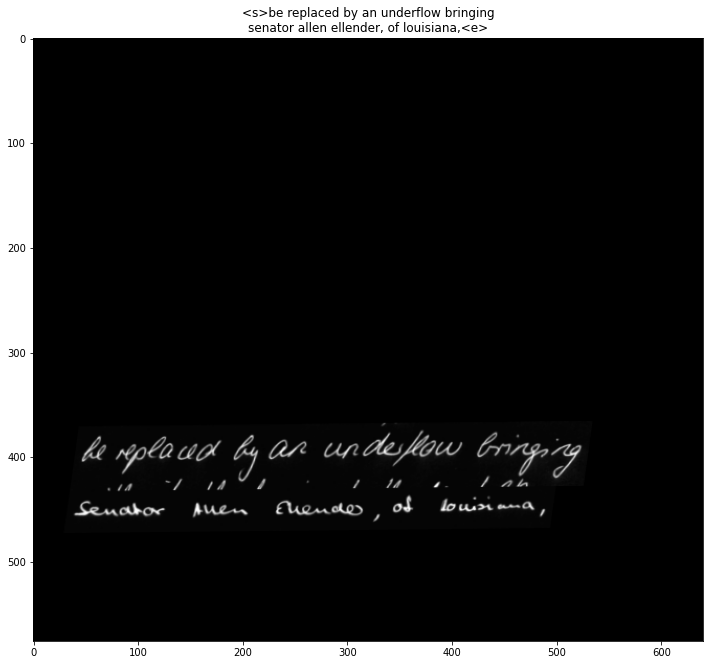

In [9]:
# Training
dataset = datamodule.data_train
for _ in range(5):
    i = random.randint(0, len(dataset))
    x, y = dataset[i]
    _plot(x[0], vmax=1, title=convert_y_label_to_string(y, datamodule.mapping))

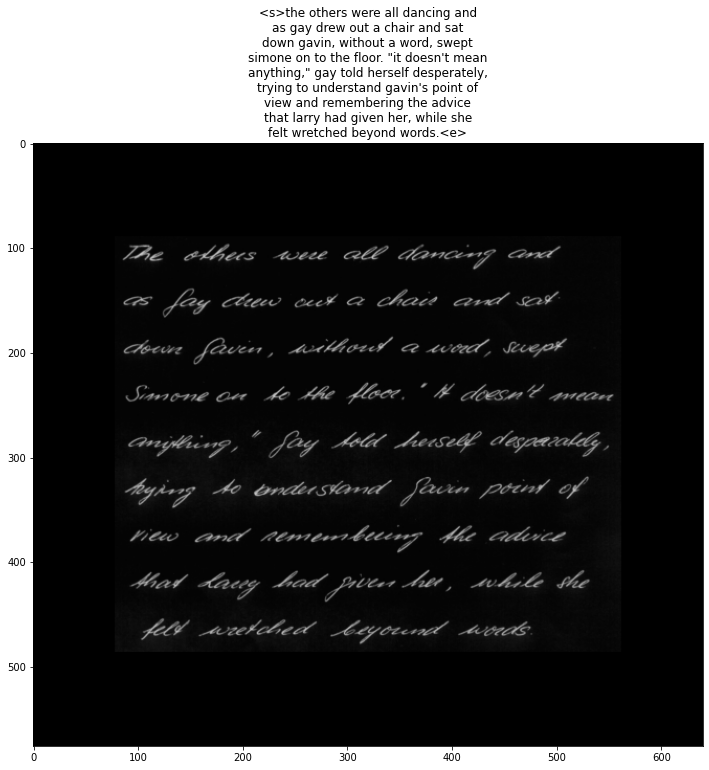

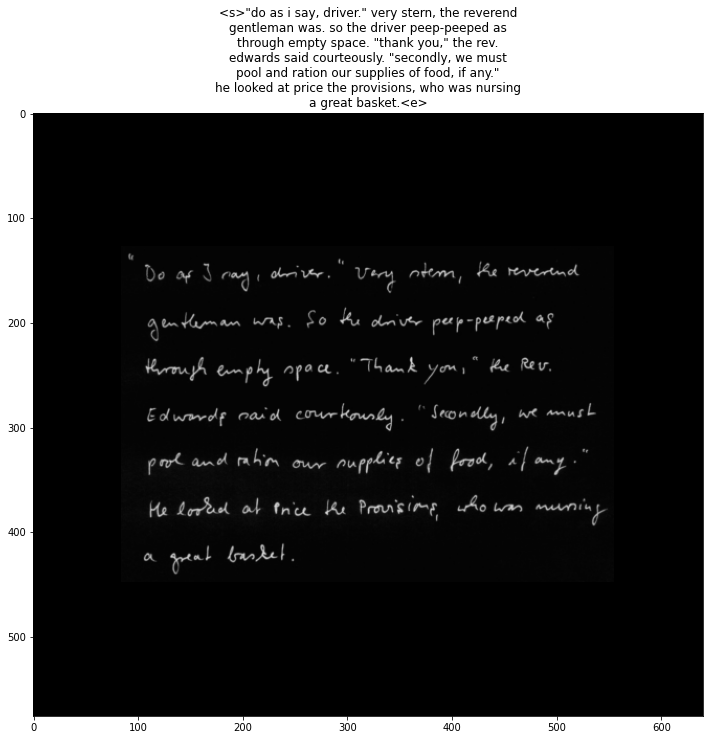

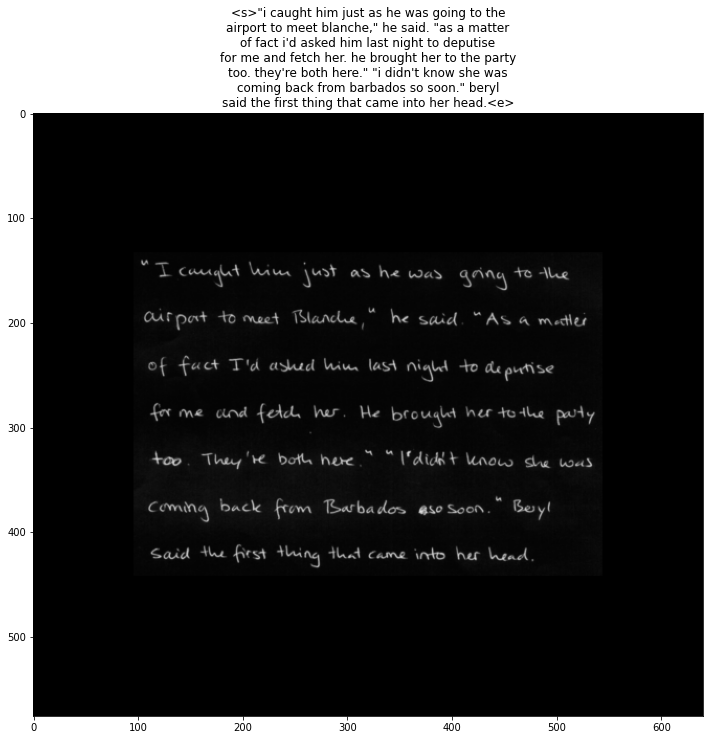

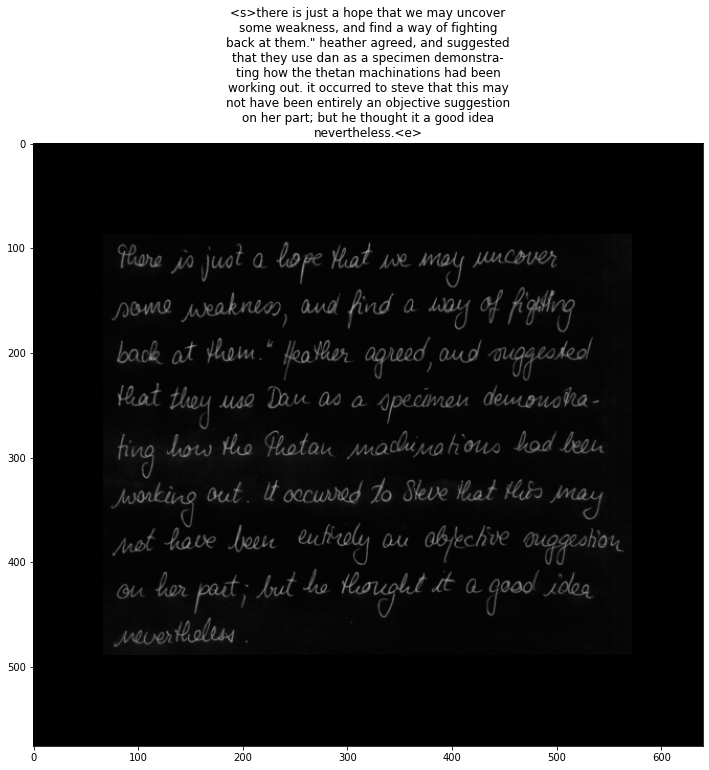

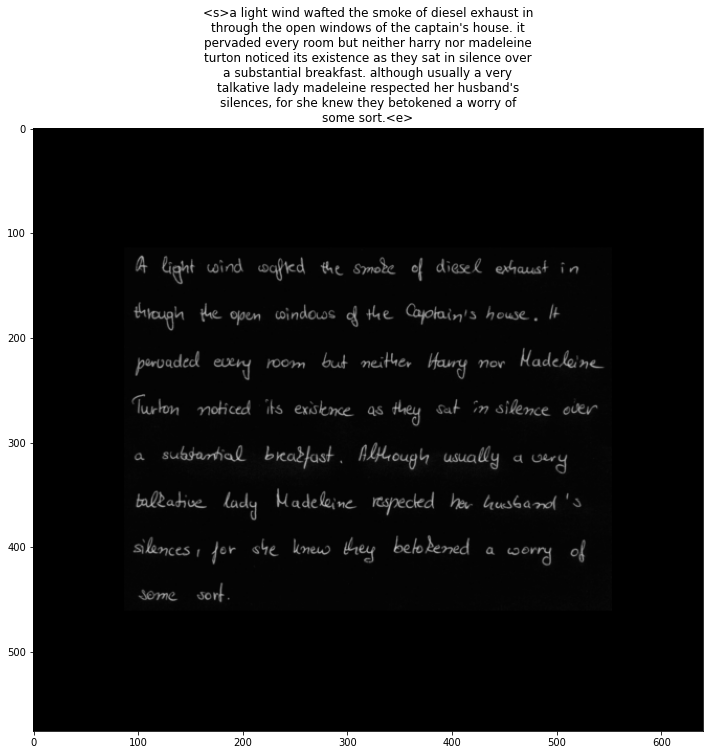

In [16]:
# Testing
dataset = datamodule.data_test
for _ in range(5):
    i = random.randint(0, len(dataset))
    x, y = dataset[i]
    _plot(x[0], vmax=1, title=convert_y_label_to_string(y, datamodule.mapping))